In [ ]:
import os
import pandas as pd

# Path to the new combined dataset folder and CSV file
combined_folder = "/content/drive/MyDrive/DR/dataset_full"
combined_csv = "/content/drive/MyDrive/DR/Full_cleaned_final.csv"

# Count the number of images in the folder
num_images = len([f for f in os.listdir(combined_folder)])

# Check if CSV exists and count its entries
if os.path.exists(combined_csv):
    df_combined = pd.read_csv(combined_csv)
    num_entries = len(df_combined)
else:
    num_entries = 0

# Print the results
print(f"Number of images in '{combined_folder}': {num_images}")
print(f"Number of entries in '{combined_csv}': {num_entries}")


Number of images in '/content/drive/MyDrive/DR/dataset_full': 5000
Number of entries in '/content/drive/MyDrive/DR/Full_cleaned_final.csv': 5000


In [ ]:
from google.colab import drive
import torch
import pandas as pd
import os
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from transformers import ViTForImageClassification
from torch.optim import AdamW

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm


# Define device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define dataset paths
image_folder = "/content/drive/MyDrive/DR/dataset_full"  # Folder containing images
csv_file = "/content/drive/MyDrive/DR/Full_cleaned_final.csv"  # CSV with image names & labels
model_save_path = "/content/drive/MyDrive/saved_models_final"  # Folder to save models
os.makedirs(model_save_path, exist_ok=True)  # Create if not exists

# Load CSV file
df = pd.read_csv(csv_file)  # Assumes 'id_code' and 'diagnosis' columns
df['id_code'] = df['id_code'].apply(lambda x: os.path.join(image_folder, x + ".png"))  # Construct full image path




In [ ]:
# Define train-test split (80-20)
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['diagnosis'], random_state=42)

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Custom Dataset Class
class EyeDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]  # Image path
        label = int(self.dataframe.iloc[idx, 1])  # Diagnosis label

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Create dataset instances
train_dataset = EyeDataset(train_df, transform=transform)
test_dataset = EyeDataset(test_df, transform=transform)

# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Print dataset info
print("Number of Classes:", len(df['diagnosis'].unique()))
print("Train Samples:", len(train_dataset), "| Test Samples:", len(test_dataset))

# Load Pretrained ViT Model
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(df['diagnosis'].unique())
)
model.to(device)


Number of Classes: 5
Train Samples: 4000 | Test Samples: 1000


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [ ]:
# Define Optimizer and Loss Function
optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss()

# Training Loop
num_epochs = 15  # Train for 10 epochs
best_train_acc = 0.0
best_epoch = 0

for epoch in range(num_epochs):
    model.train()
    running_loss, correct_train = 0.0, 0
    all_preds, all_labels = [], []

    print(f"\n🔄 Epoch {epoch + 1}/{num_epochs} - Training...")
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.logits, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs.logits, 1)
        correct_train += (preds == labels).sum().item()

        # Store predictions for accuracy calculation
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    train_acc = 100 * correct_train / len(train_dataset)
    avg_train_loss = running_loss / len(train_loader)

    print(f"\n📊 Epoch {epoch+1}: Train Accuracy: {train_acc:.2f}% | Avg Loss: {avg_train_loss:.4f}")

    # Track best epoch
    if train_acc > best_train_acc:
        best_train_acc = train_acc
        best_epoch = epoch + 1

    # Save model for each epoch
    model_path = os.path.join(model_save_path, f"model_epoch_{epoch+1}.pth")
    torch.save(model.state_dict(), model_path)
    print(f"💾 Model saved at: {model_path}")

# Final Summary
print(f"\n🎉 Training Completed! Best Train Accuracy: {best_train_acc:.2f}% at Epoch {best_epoch}")



🔄 Epoch 1/15 - Training...


Training: 100%|██████████| 250/250 [27:12<00:00,  6.53s/it]



📊 Epoch 1: Train Accuracy: 66.83% | Avg Loss: 0.9008
💾 Model saved at: /content/drive/MyDrive/saved_models_final/model_epoch_1.pth

🔄 Epoch 2/15 - Training...


Training: 100%|██████████| 250/250 [05:14<00:00,  1.26s/it]



📊 Epoch 2: Train Accuracy: 76.58% | Avg Loss: 0.6292
💾 Model saved at: /content/drive/MyDrive/saved_models_final/model_epoch_2.pth

🔄 Epoch 3/15 - Training...


Training: 100%|██████████| 250/250 [05:16<00:00,  1.27s/it]



📊 Epoch 3: Train Accuracy: 82.95% | Avg Loss: 0.4785
💾 Model saved at: /content/drive/MyDrive/saved_models_final/model_epoch_3.pth

🔄 Epoch 4/15 - Training...


Training: 100%|██████████| 250/250 [05:14<00:00,  1.26s/it]



📊 Epoch 4: Train Accuracy: 88.00% | Avg Loss: 0.3590
💾 Model saved at: /content/drive/MyDrive/saved_models_final/model_epoch_4.pth

🔄 Epoch 5/15 - Training...


Training: 100%|██████████| 250/250 [05:15<00:00,  1.26s/it]



📊 Epoch 5: Train Accuracy: 91.95% | Avg Loss: 0.2548
💾 Model saved at: /content/drive/MyDrive/saved_models_final/model_epoch_5.pth

🔄 Epoch 6/15 - Training...


Training: 100%|██████████| 250/250 [05:13<00:00,  1.25s/it]



📊 Epoch 6: Train Accuracy: 94.47% | Avg Loss: 0.1805
💾 Model saved at: /content/drive/MyDrive/saved_models_final/model_epoch_6.pth

🔄 Epoch 7/15 - Training...


Training: 100%|██████████| 250/250 [05:14<00:00,  1.26s/it]



📊 Epoch 7: Train Accuracy: 96.12% | Avg Loss: 0.1339
💾 Model saved at: /content/drive/MyDrive/saved_models_final/model_epoch_7.pth

🔄 Epoch 8/15 - Training...


Training: 100%|██████████| 250/250 [05:15<00:00,  1.26s/it]



📊 Epoch 8: Train Accuracy: 97.08% | Avg Loss: 0.1002
💾 Model saved at: /content/drive/MyDrive/saved_models_final/model_epoch_8.pth

🔄 Epoch 9/15 - Training...


Training: 100%|██████████| 250/250 [05:14<00:00,  1.26s/it]



📊 Epoch 9: Train Accuracy: 96.88% | Avg Loss: 0.0974
💾 Model saved at: /content/drive/MyDrive/saved_models_final/model_epoch_9.pth

🔄 Epoch 10/15 - Training...


Training: 100%|██████████| 250/250 [05:15<00:00,  1.26s/it]



📊 Epoch 10: Train Accuracy: 98.75% | Avg Loss: 0.0517
💾 Model saved at: /content/drive/MyDrive/saved_models_final/model_epoch_10.pth

🔄 Epoch 11/15 - Training...


Training: 100%|██████████| 250/250 [05:13<00:00,  1.25s/it]



📊 Epoch 11: Train Accuracy: 97.12% | Avg Loss: 0.0844
💾 Model saved at: /content/drive/MyDrive/saved_models_final/model_epoch_11.pth

🔄 Epoch 12/15 - Training...


Training: 100%|██████████| 250/250 [05:12<00:00,  1.25s/it]



📊 Epoch 12: Train Accuracy: 97.67% | Avg Loss: 0.0686
💾 Model saved at: /content/drive/MyDrive/saved_models_final/model_epoch_12.pth

🔄 Epoch 13/15 - Training...


Training: 100%|██████████| 250/250 [05:13<00:00,  1.25s/it]



📊 Epoch 13: Train Accuracy: 98.12% | Avg Loss: 0.0627
💾 Model saved at: /content/drive/MyDrive/saved_models_final/model_epoch_13.pth

🔄 Epoch 14/15 - Training...


Training: 100%|██████████| 250/250 [05:13<00:00,  1.26s/it]



📊 Epoch 14: Train Accuracy: 97.83% | Avg Loss: 0.0588
💾 Model saved at: /content/drive/MyDrive/saved_models_final/model_epoch_14.pth

🔄 Epoch 15/15 - Training...


Training: 100%|██████████| 250/250 [05:14<00:00,  1.26s/it]



📊 Epoch 15: Train Accuracy: 97.03% | Avg Loss: 0.0808
💾 Model saved at: /content/drive/MyDrive/saved_models_final/model_epoch_15.pth

🎉 Training Completed! Best Train Accuracy: 98.75% at Epoch 10


In [ ]:
import torch
from tqdm import tqdm
from sklearn.metrics import accuracy_score

# Load the best model
model.load_state_dict(torch.load("/content/drive/MyDrive/saved_models/model_epoch_9.pth", map_location=device))
model.eval()  # Set model to evaluation mode

# Ensure CUDA memory is cleared
torch.cuda.empty_cache()

# Define test DataLoader (reduce num_workers)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

# Evaluate on Test Set
print("\n🔍 Evaluating on Test Set...")
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        _, preds = torch.max(outputs.logits, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute Test Accuracy
test_acc = accuracy_score(all_labels, all_preds)
print(f"\n✅ Test Accuracy: {test_acc * 100:.2f}%")



🔍 Evaluating on Test Set...


Testing: 100%|██████████| 368/368 [09:16<00:00,  1.51s/it]


✅ Test Accuracy: 92.87%



🔍 Evaluating on Test Set...


Testing: 100%|██████████| 63/63 [01:29<00:00,  1.42s/it]



✅ Test Accuracy: 92.50%

📊 Classification Report:
                   precision    recall  f1-score   support

           No_DR     0.9660    0.9950    0.9803       200
            Mild     0.8489    0.9550    0.8988       200
        Moderate     0.9337    0.9150    0.9242       200
          Severe     0.9255    0.8700    0.8969       200
Proliferative_DR     0.9622    0.8900    0.9247       200

        accuracy                         0.9250      1000
       macro avg     0.9273    0.9250    0.9250      1000
    weighted avg     0.9273    0.9250    0.9250      1000



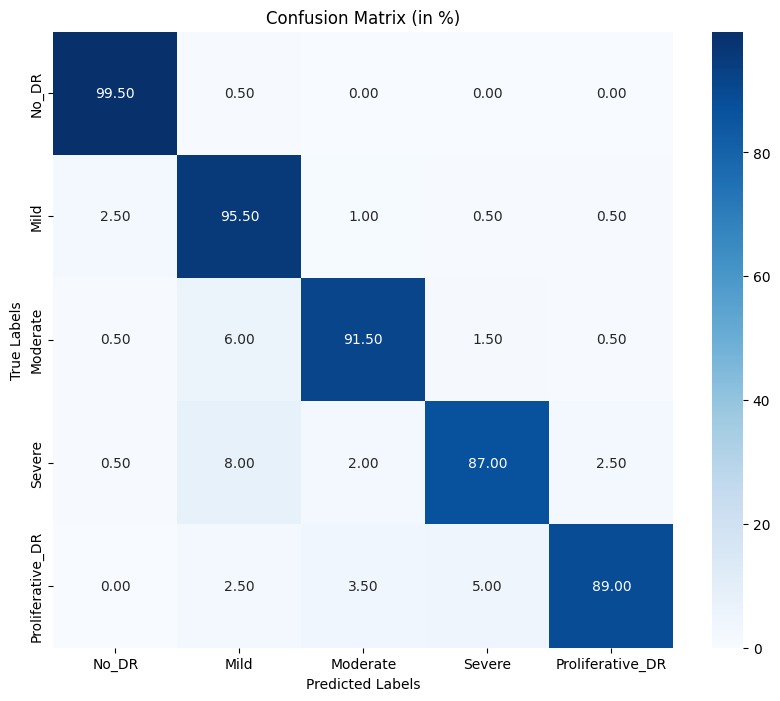

In [ ]:
import torch
from tqdm import tqdm
from sklearn.metrics import accuracy_score

# Load the best model
model.load_state_dict(torch.load("/content/drive/MyDrive/saved_models/model_epoch_9.pth", map_location=device))
model.eval()  # Set model to evaluation mode

# Ensure CUDA memory is cleared
torch.cuda.empty_cache()

# Define test DataLoader (reduce num_workers)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

# Evaluate on Test Set
print("\n🔍 Evaluating on Test Set...")
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        _, preds = torch.max(outputs.logits, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute Test Accuracy
test_acc = accuracy_score(all_labels, all_preds)
print(f"\n✅ Test Accuracy: {test_acc * 100:.2f}%")


from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get class names from dataset
class_names = ["No_DR", "Mild", "Moderate", "Severe", "Proliferative_DR"]

# 📝 Generate Classification Report
report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
print("\n📊 Classification Report:\n", report)

# 📉 Generate Normalized Confusion Matrix (row-wise percentage)
conf_matrix = confusion_matrix(all_labels, all_preds)
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# 🎨 Plot Normalized Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_percent, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (in %)")
plt.show()




/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


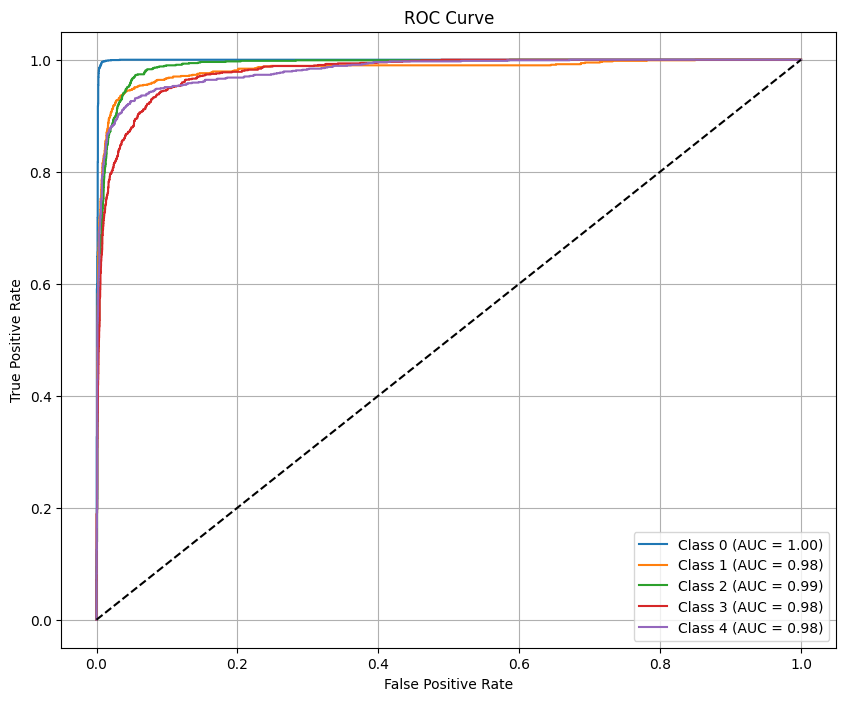

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
from sklearn.metrics import roc_curve, auc
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from transformers import ViTForImageClassification

# Load device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model_path = "/content/drive/MyDrive/saved_models/best_model.pth"
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=5)  # Adjust num_labels if needed
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Function to find image path ignoring extension
def find_image_path(image_id, folder):
    matching_files = glob.glob(os.path.join(folder, f"{image_id}.*"))  # Find any file with the same name (ignoring extension)
    return matching_files[0] if matching_files else None  # Return first match or None

# Load validation/test dataset
image_folder = "/content/drive/MyDrive/Fulldataset"
val_df = pd.read_csv("/content/drive/MyDrive/Full.csv")  # Update CSV path if needed

# Map filenames while ignoring extensions
val_df['id_code'] = val_df['id_code'].apply(lambda x: find_image_path(x, image_folder))

# Drop rows where no image was found
val_df = val_df.dropna().reset_index(drop=True)

# Define a dataset class
class EyeDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = int(self.dataframe.iloc[idx, 1])

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, label

# Create DataLoader
val_dataset = EyeDataset(val_df, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)

# Get model predictions
all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.numpy()
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1).cpu().numpy()  # Get probabilities

        all_probs.extend(probs)
        all_labels.extend(labels)

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# Compute ROC Curve
plt.figure(figsize=(10, 8))
for i in range(5):  # 5 classes (adjust if needed)
    fpr, tpr, _ = roc_curve(all_labels == i, all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()
